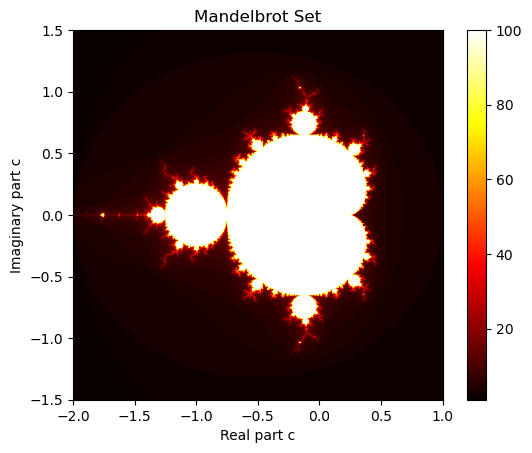

In [ ]:
## More simple example: https://www.youtube.com/watch?v=xjjmkg9J7Gg
import matplotlib.pyplot as plt
import numpy as np
from numba import jit

## The mandelbrot set consists of the set of param value c where the Julia set of z^2 + c produces a connected result (i.e. the plotted shape is continuous and is not split)
# we can determine if a Julia set is connected easily by examining the orbit of the initial condition of z_0 = 0.
# If the orbit does not tend to infinity then it is connected, if it does then it is a disconnected set. This is called the Critical Orbit.
# So, the mandelbrot consists of the parameter c values for Julia sets whose orbits do not tend to infinity when initial condition z = 0. 
@jit(nopython=True)
def mandelbrot(c, max_iter):
    z = 0 # initial condition for the critical orbit

    # iterate the function z^2 + c where c is a variable parameter
    for n in range(max_iter):
        # escape algorithm - does formula diverge to infinity as it is iterated over? if yes, it is not part of the set

        # Why is the bound 2?
            # z = z**2 + c. 
            # If  abs(z) > 2  then  abs(z**2) > 4. Then there is no way back if abs(c) <=2.
            # (If abs(c) > 2 then c**2 + c > c  and it will always diverge.)
        if abs(z) > 2: # we bound at + or -2 to say if it exceeds that, then it escapes to infinity. There is reason for this on p.253 of Feldman book. 
            return n # n will be less than max iterations and is a signal that it is not part of the set (will be colored darkly in the plot)
        # equation to iterate:
        z = (z ** 2) + c
    return max_iter # if no z result escapes, then return the max iteration number to signal non-divergence (it is a connected Julia set c param)

@jit(nopython=True)
def mandelbrot_set(*, xmin, xmax, ymin, ymax, width, height, max_iter): 
    # generate a set of values to use on the complex plane (for the z value)
    x = np.linspace(xmin,xmax,width) # real parts ; we use x and y vals to generate the c complex parameter for each iter in the formula
    y = np.linspace(ymin,ymax,height) # imaginary parts
    mset = np.zeros((height, width)) # same shape as the x and y that make the c parameter above. We store which indices are part of the mandelbrot set here to form the picture

    for i in range(height):
        for j in range(width):
            c = complex(x[j],y[i]) # compute the c complex parameter using generated vals above - we go through a lot of c values instead of having it fixed as in the julia set
            # collect the number returned to indicate whether it escaped (less than max iters) or not (returns max iters)
            mset[i,j] = mandelbrot(c, max_iter) # save the results corresponding to the x and y representing both a pixel location and the c value used in the iterated formula.
    
    return mset


xmin,xmax,ymin,ymax = -2.0,1.0,-1.5,1.5

mandelbrot_image = mandelbrot_set(
    xmin=xmin,
    xmax=xmax,
    ymin=ymin,
    ymax=ymax,
    width=1000, # how big the image is in pixels width by height
    height=1000,
    max_iter=100 # times to iterate the mandelbrot function z^2 + c
)

# print(mandelbrot_image)

plt.imshow(mandelbrot_image, extent=[xmin,xmax,ymin,ymax], cmap='hot' ) # can use others like spectral. the set will be colored according to the max iterations acheived from the function
plt.colorbar() # show color ranges for larger iteration values (took longer to diverge to infinity)
plt.title('Mandelbrot Set')
plt.xlabel('Real part c')
plt.ylabel('Imaginary part c')
plt.show()

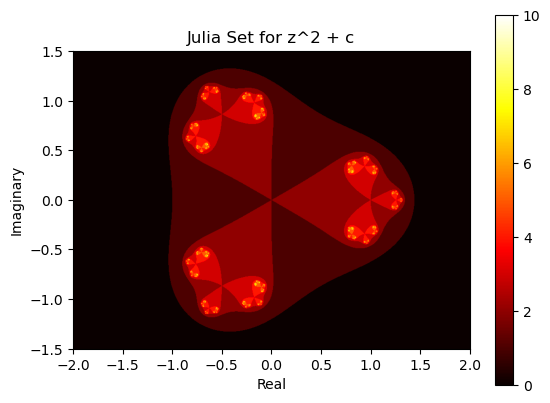

In [2]:
### Julia Set

import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# parameter c - different values to produce various julia sets
river_c = 0.84j # produces river like julia set
julia_c = -1 # produces classic julia set
connected_c = -0.6 + 0.2j # compare this with spiral_c - 1
disconnected_c = 0 - 0.72j # compare with disconnected_c**2 - produces connected set, also multiplying by julia_c reverses the image
spiral_c = 0.37 + 0.37j

c =  julia_c

@jit(nopython=True) # this compiles to machine code and greatly speeds up iteration
def julia_set(z, c, iterations_count=100, threshold=2.0):
    for i in range(iterations_count):
        z = z**3 + c
        if np.abs(z) > threshold:
            return i
    return iterations_count

# could not use jit decorator here because ogrid is not supported by the function
def generate_julia_set(min_coordinate, max_coordinate, width, height, iterations_count=100):
    imaginary_axis, real_axis = np.ogrid[
        min_coordinate.imag: max_coordinate.imag: height * 1j,
        min_coordinate.real: max_coordinate.real: width * 1j]
    # TODO: why does using c = z[i,j] in loop make the mandelbrot set? (initial z should have to be zero to check which c params are bounded for mandelbrot set..)
    z = real_axis + 1j * imaginary_axis # a complex number - the real part plus the imaginary part
    
    result = np.empty_like(z, dtype=int)

    for i in range(height):
        for j in range(width):
            # to get mandelbrot use c = z[i,j]
            result[i, j] = julia_set(z[i, j], c=c, iterations_count=iterations_count)

    return result

# Set parameters
min_coordinate = -2 - 1.5j
max_coordinate = 2 + 1.5j
width = 800
height = 600

# Generate Julia set
julia_image = generate_julia_set(min_coordinate, max_coordinate, width, height)

# Display the plot
plt.imshow(julia_image, cmap='hot', extent=(min_coordinate.real, max_coordinate.real, min_coordinate.imag, max_coordinate.imag))
# plt.imshow(julia_image,
#             cmap='nipy_spectral',
#             origin='lower')
plt.title("Julia Set for z^2 + c")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.colorbar()
plt.show()


In [4]:

# numba uses just in time compilation for more efficient processing
from numba import jit
from functools import partial
from numbers import Complex
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np

# using Pillow: https://www.geeksforgeeks.org/julia-fractal-python/

## From https://codereview.stackexchange.com/questions/210271/generating-julia-set


# *, means every following arg must be specified as a keyword argument when called
def julia_set(*,
              fn: Callable[[Complex], Complex],
              min_coordinate: Complex,
              max_coordinate: Complex,
              width: int,
              height: int,
              iterations_count: int = 256,
              threshold: float = 2.) -> np.ndarray:
    """
    :param mapping: function defining Julia set
    :param min_coordinate: bottom-left complex plane coordinate
    :param max_coordinate: upper-right complex plane coordinate
    :param height: pixels in vertical axis
    :param width: pixels in horizontal axis
    :param iterations_count: number of iterations
    :param threshold: if the magnitude of z becomes greater
    than the threshold we assume that it will diverge to infinity
    :return: 2D pixels array of intensities
    """
    # np.ogrid generates an "open grid" of values. This means it doesn't create the full array in memory but provides a way to access the values as if it did
    # if you need to evaluate a function on a grid of points and you're only using a small portion of that grid, np.ogrid can help you avoid unnecessary memory usage.
    imaginary_axis, real_axis = np.ogrid[
                        min_coordinate.imag: max_coordinate.imag: height * 1j,
                        min_coordinate.real: max_coordinate.real: width * 1j] # using 1j instead of 1 offers some kind of easier way to specify steps with np.ogrid - you don't need to calculate the step size this way
    
    z = real_axis + 1j * imaginary_axis # array of z values for each pixel in the image
    live, = np.indices(z.shape)[0] # indexes of pixels that have not escaped, not diverged to infinity
    iterations = np.empty_like(z, dtype=int)

    for i in range(iterations_count):
        z_live = z[live] = fn(z[live])
        escaped = np.abs(z_live) > threshold
        iterations[live[escaped]] = i
        live = live[~escaped]
    iterations[live] = iterations_count # indicates pixels that don't escape - they are given the value of iterations count
    return (iterations_count - iterations).reshape((height, width)) # get the non eliminated points. The subtraction could be omitted if you reverse the colour map.

# set parameters
def fn(z: Complex,*,c: Complex):
    return z ** 2 + c
func_to_iterate = partial(fn,
                    c=-0.7 + 0.27015j)  # type: Callable[[Complex], Complex]

## Run the iterations
image = julia_set(fn=func_to_iterate,
                    min_coordinate=-1.5 - 1j,
                    max_coordinate=1.5 + 1j,
                    width=800,
                    height=600)

## Show the plot
plt.axis('off')
plt.imshow(image,
            cmap='nipy_spectral',
            origin='lower')
plt.show()

ValueError: too many values to unpack (expected 1)

In [34]:
min_coordinate=-1.5 - 1j

max_coordinate=1.5 + 1j
width=2#800
height=4#600

imaginary_axis, real_axis = np.ogrid[
                        min_coordinate.imag : max_coordinate.imag : height * 1j,
                        min_coordinate.real : max_coordinate.real : width * 1j] 
print(imaginary_axis,real_axis)

z = real_axis + 1j * imaginary_axis # array of z values for each pixel in the image
print(z)
print(z.shape)
live = np.indices(z.shape)
print(live)
# live, = np.indices(z.shape)[0] # indexes of pixels that have not escaped, not diverged to infinity

[[-1.        ]
 [-0.33333333]
 [ 0.33333333]
 [ 1.        ]] [[-1.5  1.5]]
[[-1.5-1.j          1.5-1.j        ]
 [-1.5-0.33333333j  1.5-0.33333333j]
 [-1.5+0.33333333j  1.5+0.33333333j]
 [-1.5+1.j          1.5+1.j        ]]
(4, 2)
[[[0 0]
  [1 1]
  [2 2]
  [3 3]]

 [[0 1]
  [0 1]
  [0 1]
  [0 1]]]


In [ ]:
# Python code for Julia Fractal
from PIL import Image
  
# setting the width, height and zoom 
# of the image to be created
w, h, zoom = 1920,1080,1

# creating the new image in RGB mode
bitmap = Image.new("RGB", (w, h), "white")

# Allocating the storage for the image and
# loading the pixel data.
pix = bitmap.load()

# setting up the variables according to 
# the equation to  create the fractal
cX, cY = -0.7, 0.27015
moveX, moveY = 0.0, 0.0
maxIter = 255

for x in range(w):
    for y in range(h):
        zx = 1.5*(x - w/2)/(0.5*zoom*w) + moveX
        zy = 1.0*(y - h/2)/(0.5*zoom*h) + moveY
        i = maxIter
        while zx*zx + zy*zy < 4 and i > 1:
            tmp = zx*zx - zy*zy + cX
            zy,zx = 2.0*zx*zy + cY, tmp
            i -= 1

        # convert byte to RGB (3 bytes), kinda 
        # magic to get nice colors
        pix[x,y] = (i << 21) + (i << 10) + i*8

# to display the created fractal
bitmap.show()